In [81]:
!pip install -q -U bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [82]:
!pip install -q -U transformers datasets peft bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Fine Tune PaliGemma with QLoRA for Visual Question Answering

In this tutorial, we will learn about PaliGemma briefly and demonstrate how to fine-tune it using the QLoRA (Quantized Low-Rank Adaptation) technique to achieve improved inference results, helping us create a custom vision-language model tailored to our specific tasks.

PaliGemma is an open Vision-Language Model (VLM) released by Google. It builds on the PaLI (Pathways Language and Image) series and the Gemma family of language models.

While many VLMs are getting larger to handle more tasks, PaliGemma focuses on being smaller and more efficient.


* Compact Size: Only about 3B parameters, significantly smaller than many VLMs.
* Competitive Performance: Can be fine-tuned to match the capabilities of larger models.
* Adaptability: Efficient and easy to customize for various tasks.

## What Is a Vision-Language Model?

A Vision-Language Model (VLM) combines visual and textual understanding, processing images and text simultaneously to grasp their relationship. This enables VLMs to handle tasks like image captioning, visual question answering, and more.

How VLMs Work

Image Processing: A component specifically trained to interpret visual data.
Language Processing: Another component designed to handle textual information.
Joint Understanding: The model learns how visuals and language relate, enabling it to describe images or answer questions about them.
For example, a VLM can look at a picture of a dog and generate a descriptive sentence about it.

As VLMs have evolved, they have become more powerful, with larger models able to handle more complex tasks.

However, recent efforts also focus on creating smaller, more efficient VLMs (e.g., PaliGemma) that can perform just as well without massive computational resources.

## Architecture of PaliGemma
PaliGemma is a simple input+text-in, text-out model that takes an image and text as input and generates text as output. PaliGemma’s architecture is built on three key components:

### Image Encoder

PaliGemma uses the SigLIP (Sigmoid loss for Language-Image Pre-training) checkpoint, a publicly available image encoder.
Specifically, it leverages the “shape optimized” Vision Transformer (ViT So400m).
This model is pre-trained on a large scale using contrastive learning with a sigmoid loss, enabling it to process and understand images effectively.
### Decoder-Only Language Model

PaliGemma integrates the Gemma-2B model, a publicly available pre-trained language model for the language component.
As a decoder-only model, it is designed to generate text based on both image and language inputs, allowing for tasks like image captioning or answering questions about an image.
### Linear Layer Projection

The output tokens from the SigLIP encoder are linearly projected into the same dimension as the Gemma-2B model’s vocabulary tokens.
This linear projection ensures that the image and language features can be seamlessly combined and used for downstream tasks.


## How Is PaliGemma Trained?
Inspired by the Pathways Language and Image (PaLI-3) models, PaliGemma follows the same training stages. The training stages are as follows:

### Stage 0: Unimodal Pretraining

* The unimodal components of PaliGemma are pre-trained individually to leverage established training methods.
* No custom unimodal pre-training is performed; publicly available checkpoints are utilized.
* A SigLIP image encoder, specifically the “shape optimized” ViT-So400m model, is smaller yet effective compared to larger models like ViT-G.
* The model adopts the Gemma-2B decoder-only language model, balancing size and performance.
### Stage 1: Multimodal Pretraining

* This stage combines unimodal models and trains them on various vision-language tasks.
* The focus is on creating a base model that can be fine-tuned well for diverse tasks rather than just aligning modalities.
* The image encoder remains frozen initially to maintain representation quality, although it later learns from tasks that provide valuable signals.
* Training occurs at 224px resolution with 1 billion examples, aiming to cover a wide array of concepts and languages.
### Stage 2: Resolution Increase

* The model from Stage 1 is valuable but limited to 224×224 pixel resolution, which is insufficient for tasks requiring higher detail.
* Two additional checkpoints are trained at resolutions of 448×448 and 896×896 pixels.
* Stage 2 emphasizes increasing resolution while retaining the task diversity from Stage 1, with fewer examples but higher information density.
* The text sequence length is increased to 512 tokens for tasks that demand detailed input.
### Stage 3: Transfer

* Stages 1 and 2 produce checkpoints at different resolutions rich in visual knowledge.
* These models need to be fine-tuned for specific tasks to be user-friendly.
* The model can be adapted for various inputs, including multiple images and bounding boxes.


## Available Model Checkpoints
Google has released three types of PaliGemma models:

1. **Pretrained Checkpoints**: These are base models trained on large datasets that can be further fine-tuned for specific downstream tasks.
1. **Mix Checkpoints**: These base models have been fine-tuned on various tasks, making them easy to use with general-purpose free-text prompts.
1. **Fine-Tuned Checkpoints**: These base models have been fine-tuned for specific tasks, providing targeted performance for particular applications.

## Use Cases of PaliGemma
Keeping vision applications in mind, here are some tasks PaliGemma can be used for:

* Image and Short Video Captioning: Asking the model to generate descriptive captions for pictures or short videos.
* Visual Question Answering: Asking the model to generate relevant answers to specific questions about an image.
* Document Understanding: Asking the model to generate answers to specific questions about the text shown in the image.
* Diagram Understanding: Asking the model to generate answers to specific questions about diagrams shown in the image.
* Object Detection: Asking the model to identify (output bounding box coordinates) and label objects within an image.
* Object Segmentation: Asking the model to segment (output polygon coordinates) that bound the detected objects in an image (shown in Figure 2).
* Science Question Answering: Asking the model to provide specific answers to questions related to scientific content, using visual inputs like graphs or diagrams in addition to text.

## Why PaliGemma?
PaliGemma’s compact architecture makes it highly effective across multiple tasks while keeping the model size manageable.\
Its key components (e.g., an image encoder, a language decoder, and a projection layer) allow it to handle complex tasks without requiring the massive computational power that larger models might need.\
Overall, PaliGemma’s flexibility makes it a powerful tool for any task requiring a deep understanding of images and text.

In [83]:
import transformers

We import the necessary libraries.

We import torch to provide support for tensor computation. \
We import requests to send HTTP requests for downloading images from the internet.\
We import Image from PIL to open, manipulate, and process images.\
From the transformers library, we import AutoProcessor and PaliGemmaForConditionalGeneration to work with the PaliGemma model.

In [84]:
import torch
import requests
from PIL import Image
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration

We import the notebook_login function from the huggingface_hub library, which authenticates our Hugging Face account in a notebook environment.\
We run notebook_login, which prompts us to enter a Hugging Face API token to log in to access Hugging Face models and datasets.


In [ ]:
from huggingface_hub import login
login(token = "API_HERE")

In [ ]:
import os
os.environ["WANDB_API_KEY"] = "API_HERE"

import wandb
wandb.login()

True

We define a string variable pretrained_model_id with the identifier for the specific PaliGemma pre-trained model (3B parameters, 224px resolution) from the Hugging Face Model Hub.\
We load the pre-trained processor associated with the specified pretrained_model_id. It is responsible for pre-processing input data (e.g., tokenizing text or resizing images) and post-processing the model’s outputs (e.g., decoding).\
We load the pre-trained PaliGemma model associated with the specified pretrained_model_id. It is responsible for generating text outputs based on the inputs (image + text) provided.

In [87]:
# pretrained_model_id = "google/paligemma-3b-pt-224"
# processor = AutoProcessor.from_pretrained(pretrained_model_id)
# pretrained_model = PaliGemmaForConditionalGeneration.from_pretrained(pretrained_model_id)

* We define the prompt as a text input.
* We assign the URL of an image to the variable image_file. The image is hosted on the Hugging Face dataset repository.
* We download the image from the URL using the requests library and open it using the PIL library (Image.open()). stream=True ensures that the file is streamed in memory rather than downloaded fully before opening.
* We process the image (raw_image) and the text prompt (prompt) using the AutoProcessor. We convert the image to RGB format and prepare the inputs for the model. return_tensors="pt" returns the processed data as PyTorch tensors to be compatible with the pre-trained model.
* We generate the model’s output based on the processed inputs, with a maximum of 20 new tokens in the response. It tries to answer the prompt using the image and text as inputs.
* We decode the generated output from the model using processor.decode, converting the tokenized output back into human-readable text. skip_special_tokens=True removes any special tokens that the model might have generated (e.g., start/end tokens). [len(prompt):] slices the response to exclude the prompt itself, printing only the generated answer.

In [88]:
# prompt = "What is behind the cat?"
# image_file = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cat.png?download=true"
# raw_image = Image.open(requests.get(image_file, stream=True).raw)
# inputs = processor(raw_image.convert("RGB"), prompt, return_tensors="pt")
# output = pretrained_model.generate(**inputs, max_new_tokens=20)
# print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])

# Fine-Tuning PaliGemma on a Custom Dataset
Fine-tuning involves adapting a pre-trained model to a specific task or dataset by training it further on new data. This allows the model to specialize and improve performance on domain-specific tasks.

In our case, we fine-tune the PaliGemma model on a custom visual question answering dataset, vqav2-small, a small subset of the VQA v2.0 dataset hosted by Merve on Hugging Face.

The vqav2_small dataset (shown in Figure 4) consists of 21.4k examples with three features: image, question, and multiple_choice_answer. The model is trained using a combination of the image and question as input, while the multiple_choice_answer serves as the label for fine-tuning.

We import several essential libraries to facilitate our tasks.

First, we import a torch library for tensor computation support. Next, requests allows us to send HTTP requests for downloading images from the internet, while PIL is utilized to open, manipulate, and process these images.

The load_dataset function from the datasets library enables us to load datasets for training and evaluation.

Additionally, we import get_peft_model and LoraConfig from the peft library; the former helps create a model with parameter-efficient fine-tuning (PEFT) techniques, and the latter configures the Low-Rank Adaptation (LoRA) method for fine-tuning.

To simplify the training and evaluation of models, we bring in the Trainer class and set the training configuration using TrainingArguments from the transformers library.

The PaliGemmaProcessor is essential for preparing inputs for the PaliGemma model and managing preprocessing tasks (e.g., tokenization).

For optimizing memory usage and computational efficiency during the training of large models, we utilize BitsAndBytesConfig to configure options related to quantization.

Finally, the AutoProcessor automatically selects the appropriate processor based on the model, and the PaliGemmaForConditionalGeneration class is used to generate outputs based on the input data.

In [89]:
import torch
import requests
from PIL import Image
from datasets import load_dataset
from peft import get_peft_model, LoraConfig
from transformers import Trainer
from transformers import TrainingArguments
from transformers import PaliGemmaProcessor
from transformers import BitsAndBytesConfig
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration

We use the load_dataset function from the datasets library to load the dataset merve/vqav2-small, hosted by Merve on Hugging Face.

In [90]:
ds = load_dataset('caglarmert/small_riscm')

In [91]:
ds_dataframe = ds['train'].to_pandas()

## Split the Dataset into Train-Test
We use the train_test_split method to split the dataset into training and testing sets. We specify a test_size of 0.05, meaning that 5% of the data will be allocated for testing.

In [92]:
split_ds = ds["train"].train_test_split(test_size=0.05)
train_ds = split_ds["train"]
test_ds = split_ds["test"]

We initialize the PaliGemmaProcessor using a pre-trained model specified by model_id and define a custom collate_fn function to preprocess a list of examples from the dataset. This function performs several key tasks:

* Formats each example’s question into a text prompt with special tokens.
* Extracts the multiple-choice answers and stores them in a list called labels.
* Converts each image in the examples to RGB format, collecting them in a list named images.
* Next, we utilize the PaliGemmaProcessor to tokenize the text, images, and labels, returning the processed data as PyTorch tensors with padding to the longest sequence.
* For efficiency, we convert the processed tensors to the bfloat16 data type and move them to the specified device, which is the GPU in this case.
* Finally, the function returns the processed tokens, making them ready for input into the model.

In [93]:
device = "cuda"
model_id = "google/paligemma-3b-pt-224"

In [94]:
processor = PaliGemmaProcessor.from_pretrained(model_id)
def collate_fn(examples):
      texts = ["<image> <bos> describe this image.}" for example in examples]
      labels= [example['caption'] for example in examples]
      images = [example["image"].convert("RGB") for example in examples]
      tokens = processor(text=texts, images=images, suffix=labels,
      return_tensors="pt", padding="longest")
      tokens = tokens.to(torch.bfloat16).to(device)
      return tokens

## Fine-Tune Only the Text Decoder
Since our dataset closely resembles the ones PaliGemma was initially trained on, there’s no need to fine-tune the image encoder or the multimodal projector. We will focus on fine-tuning only the text decoder.

In [95]:
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16).to(device)
for param in model.vision_tower.parameters():
      param.requires_grad = False
for param in model.multi_modal_projector.parameters():
      param.requires_grad = False

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Using the QLoRA Technique
Now, we set up the configuration to use the Quantized Low-Rank Adapters (QLoRA) technique for model optimization and fine-tuning.

## BitsAndBytesConfig
* load_in_4bit=True: enables 4-bit quantization to reduce memory consumption.\
* bnb_4bit_quant_type="nf4": specifies the quantization type, here using "nf4" for more efficient weight representation.\
* bnb_4bit_compute_dtype=torch.bfloat16: sets the computation to use bfloat16 to improve computational efficiency during training.

In [96]:
bnb_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_quant_type="nf4",
      bnb_4bit_compute_dtype=torch.bfloat16
)
lora_config = LoraConfig(
      r=8, # 4 - 8 - 16
      target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
      task_type="CAUSAL_LM",
)

## LoraConfig
* r=8: sets the rank (number of dimensions) for low-rank adaptation.
* target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"]: specifies which modules to fine-tune within the model’s language tower (e.g., query, key, and value projections).
* task_type="CAUSAL_LM": defines the task type for the fine-tuning, in this case, causal language modeling.

In [97]:
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


## Define the Training Arguments
We define the training arguments for fine-tuning a model using the Hugging Face Trainer API, including configurations for the number of epochs, batch size, learning rate, optimizer, logging, and saving checkpoints.

We set up the training configuration by specifying key parameters such as training for 2 epochs, a batch size of 4 per device, and accumulating gradients over 4 steps to simulate a larger batch size.

To ensure stability during early training, we include 2 warmup_steps and use a learning_rate of 2e-5 with a small weight_decay of 1e-6 for regularization. The adamw_hf optimizer is configured with an adam_beta2 value of 0.999, and metrics are logged every 100 steps using logging_steps.

We also save model checkpoints every 1,000 steps (as specified by save_steps), limiting the number of saved checkpoints to 1 (using save_total_limit). The checkpoints are stored in the finetuned_paligemma_vqav2_small directory, as defined in output_dir.

Additionally, we enable bfloat16 precision (bf16=True) to reduce memory usage and disable data loader memory pinning (dataloader_pin_memory=False), which can help decrease memory overhead in specific environments.

Finally, we set report_to=["tensorboard"] to log the training progress.

In [98]:
exp_config_name="finetuned_paligemma_riscm_small_v6"

In [99]:
args=TrainingArguments(
      num_train_epochs=100,
      per_device_train_batch_size=2,
      gradient_accumulation_steps=4,
      warmup_steps=2,
      learning_rate=2e-5,
      weight_decay=1e-6,
      adam_beta2=0.999,
      logging_steps=2,
      optim="adamw_8bit",
      save_strategy="steps",
      save_steps=10,
      save_total_limit=1,
      output_dir=exp_config_name,
      bf16=True,
      dataloader_pin_memory=False,
      report_to=["wandb"],
      remove_unused_columns=False,
)

## Training
We initialize a Hugging Face Trainer with the specified model, training dataset, data collation function, and training arguments, then start the fine-tuning process.

We create an instance of the Hugging Face Trainer class with the following parameters

The pre-trained model to be fine-tuned.\
The dataset (train_ds) and data collator (collate_fn) to handle batching and preprocessing.\
Training configurations from args to specify details (e.g., batch size and learning rate).

In [100]:
import wandb

wandb.init(
    project="remote-sense-caption",
    name=exp_config_name,
    config={
        "lora_r": 8,  # or 4 - 8 - 16
        "lora_alpha": 16,  # or 32
        "lora_dropout": 0.1,  # or 0.05
        "learning_rate": 2e-5,
        "epochs": 15,
        "batch_size": 8,
    }
)

In [101]:
trainer = Trainer(
      model=model,
      train_dataset=train_ds,
      data_collator=collate_fn,
      args=args
)
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
2,15.777800
4,15.264000
6,16.009200
8,16.032400
10,16.619300
12,16.112600
14,16.139700
16,15.671400
18,14.780000
20,14.658300


TrainOutput(global_step=1200, training_loss=2.7626474636095613, metrics={'train_runtime': 9578.7433, 'train_samples_per_second': 0.992, 'train_steps_per_second': 0.125, 'total_flos': 3.868273594434902e+16, 'train_loss': 2.7626474636095613, 'epoch': 100.0})

## Push the Fine-Tuned PaliGemma Model to the Hub
We upload our fine-tuned model, which includes the safetensors file and model configurations, to the Hub so that it can be used later for inference. The fine-tuned model can be found here: Hugging Face Model Hub.

In [102]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yek-models/finetuned_paligemma_riscm_small_v6/commit/1092dd4ae48fbf2993641b39137527a70d5f6041', commit_message='End of training', commit_description='', oid='1092dd4ae48fbf2993641b39137527a70d5f6041', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yek-models/finetuned_paligemma_riscm_small_v6', endpoint='https://huggingface.co', repo_type='model', repo_id='yek-models/finetuned_paligemma_riscm_small_v6'), pr_revision=None, pr_num=None)

# Inference with Fine-Tuned PaliGemma Model
Now, we can use our uploaded fine-tuned PaliGemma model to run inference on examples from our test split dataset.

We first initialize the processor with pretrained_model_id to handle input preprocessing. Next, we load the model using finetuned_model_id, which points to our fine-tuned version of PaliGemma.

In [103]:
pretrained_model_id = "google/paligemma-3b-pt-224"
finetuned_model_id = "yek-models/"+ exp_config_name
processor = AutoProcessor.from_pretrained(pretrained_model_id)
model = PaliGemmaForConditionalGeneration.from_pretrained(finetuned_model_id)

adapter_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

Here, we have the same inference code as before. We define the text prompt and download the image using requests, then open it with the PIL library (Image.open()). After that, we preprocess the image and prompt using the processor, generate a response from the model, and finally decode the output to get the answer.

When we ran inference with the pre-trained model, the output generated was antique, which wasn’t entirely accurate. However, after fine-tuning, the model generated a gramophone, which is a more accurate result.

In [104]:
prompt = "Describe this image."
image_file = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cat.png?download=true"
raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor(raw_image.convert("RGB"), prompt, return_tensors="pt")
output = model.generate(**inputs, max_new_tokens=40)
print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



cat .


In [105]:
prompt = "Describe this image."
image_file = test_ds[1]["image"]
inputs = processor(image_file, prompt, return_tensors="pt")
output = model.generate(**inputs, max_new_tokens=40)
print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



The roofs of the houses are dark gray .


In [106]:
prompt = "Describe this image."
image_file = test_ds[2]["image"]
inputs = processor(image_file, prompt, return_tensors="pt")
output = model.generate(**inputs, max_new_tokens=40)
print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



This image shows a railway station with some buildings and trees .


In [107]:
prompt = "Describe this image."
image_file = test_ds[3]["image"]
inputs = processor(image_file, prompt, return_tensors="pt")
output = model.generate(**inputs, max_new_tokens=40)
print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



dense forest


Reference:

https://pyimagesearch.com/2024/12/02/fine-tune-paligemma-with-qlora-for-visual-question-answering/ \
https://blog.roboflow.com/fine-tune-paligemma-2/

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


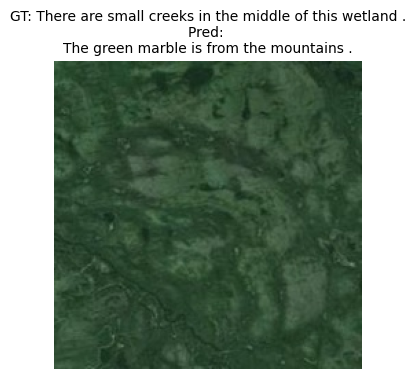

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


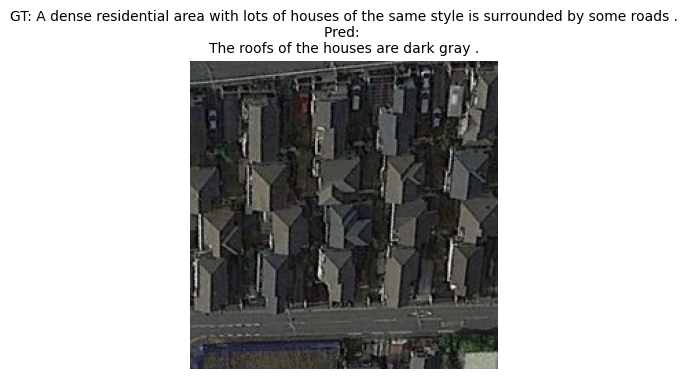

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


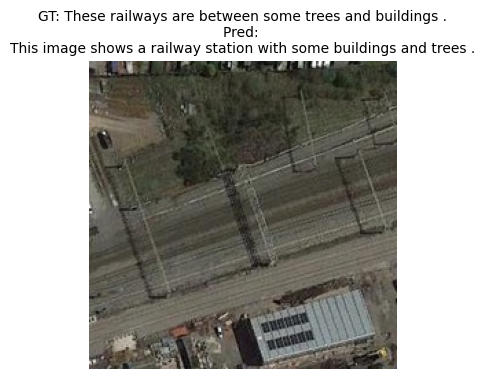

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


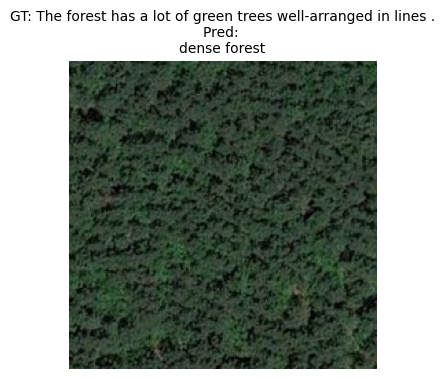

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


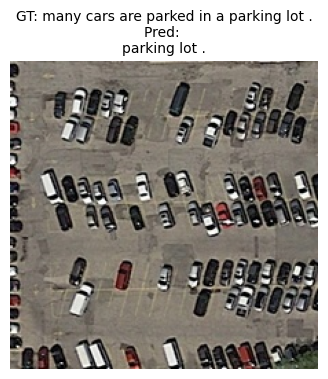

In [108]:
import matplotlib.pyplot as plt

prompt = "Describe this image."

for i in range(5):
    image_file = test_ds[i]["image"]
    ground_truth = test_ds[i]["caption"]  # adjust key if needed

    # Preprocess input
    inputs = processor(image_file, prompt, return_tensors="pt").to(model.device)

    # Generate prediction
    output = model.generate(**inputs, max_new_tokens=20)
    prediction = processor.decode(output[0], skip_special_tokens=True)[len(prompt):]

    # Display image and captions
    plt.figure(figsize=(4, 4))
    plt.imshow(image_file)
    plt.axis("off")
    plt.title(f"GT: {ground_truth}\nPred: {prediction}", fontsize=10)
    plt.show()

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


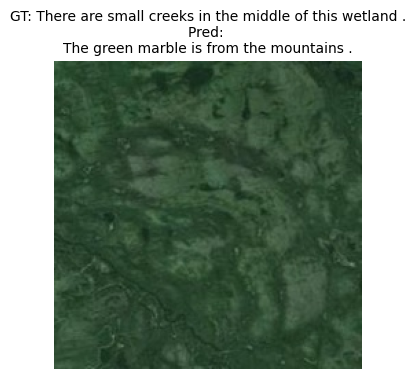

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


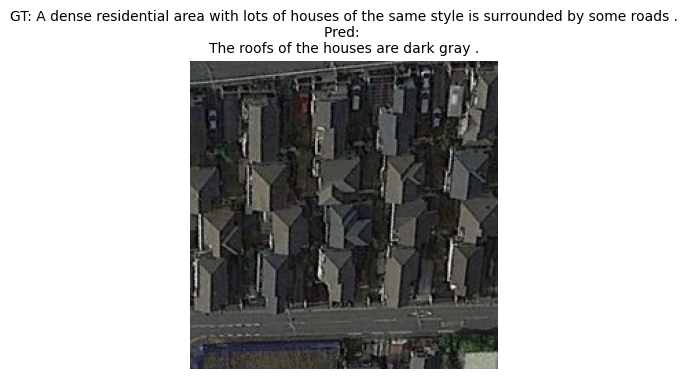

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


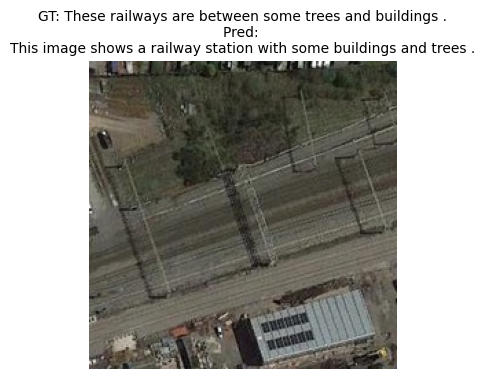

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


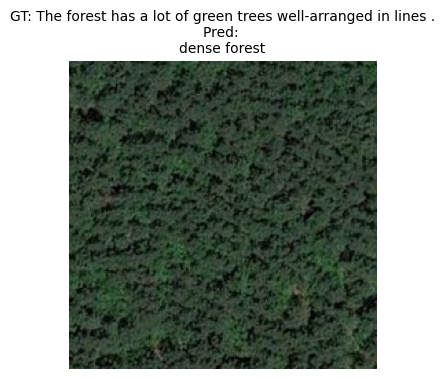

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


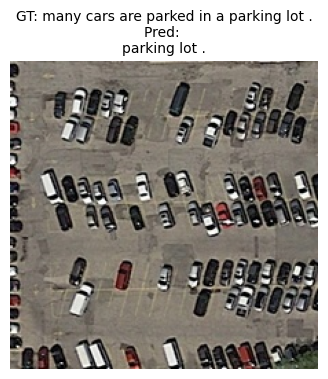

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


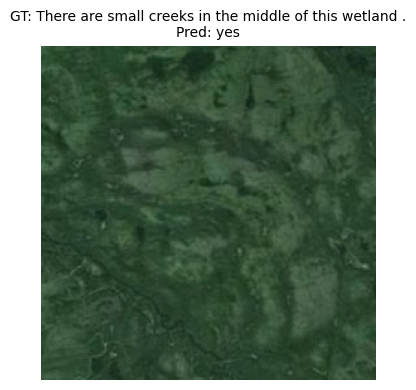

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


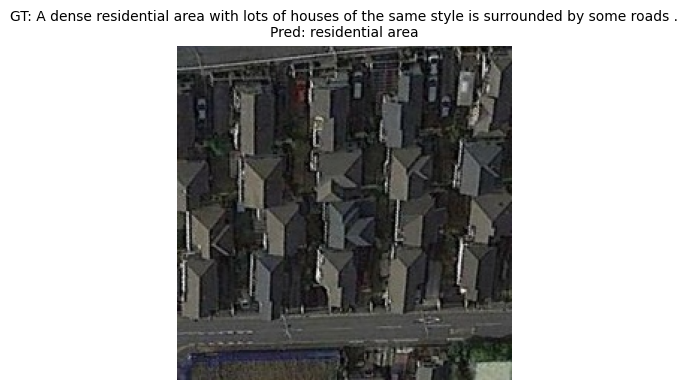

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


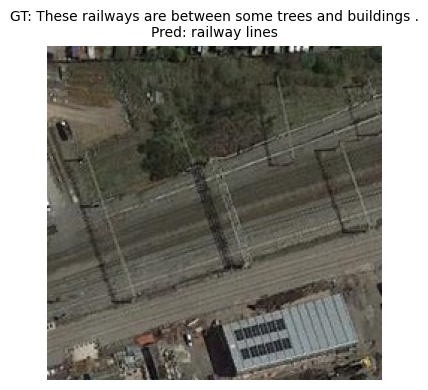

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


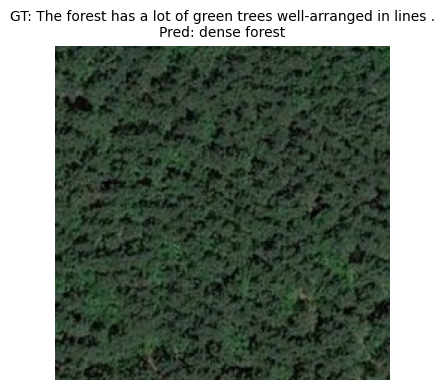

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


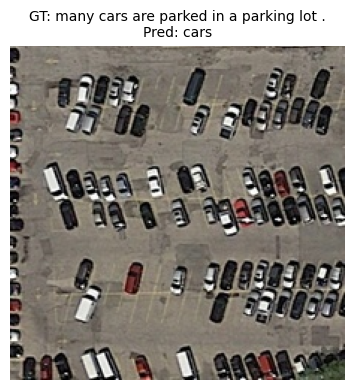

In [109]:
import matplotlib.pyplot as plt

prompt = "Describe this image."

for i in range(5):
    image_file = test_ds[i]["image"]
    ground_truth = test_ds[i]["caption"]  # adjust key if needed

    # Preprocess input
    inputs = processor(image_file, prompt, return_tensors="pt").to(model.device)

    # Generate prediction
    output = model.generate(**inputs, max_new_tokens=20)
    prediction = processor.decode(output[0], skip_special_tokens=True)[len(prompt):]

    # Display image and captions
    plt.figure(figsize=(4, 4))
    plt.imshow(image_file)
    plt.axis("off")
    plt.title(f"GT: {ground_truth}\nPred: {prediction}", fontsize=10)
    plt.show()

# Use a richer and more open-ended prompt
prompt = "What can you see in this satellite image? Describe in detail."

for i in range(5):
    image_file = test_ds[i]["image"]
    ground_truth = test_ds[i]["caption"]

    # Preprocess input
    inputs = processor(image_file, prompt, return_tensors="pt").to(model.device)

    # Generate caption with sampling (to avoid one-word outputs)
    output = model.generate(**inputs, max_new_tokens=20)

    # Decode and strip the prompt
    prediction = processor.decode(output[0], skip_special_tokens=True)
    if prediction.startswith(prompt):
        prediction = prediction[len(prompt):].strip()

    # Display image and captions
    plt.figure(figsize=(4, 4))
    plt.imshow(image_file)
    plt.axis("off")
    plt.title(f"GT: {ground_truth}\nPred: {prediction}", fontsize=10)
    plt.tight_layout()
    plt.show()


In [110]:
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [111]:
!pip install evaluate


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [112]:
from evaluate import load
from tqdm import tqdm

# Load metrics
bleu = load("bleu")
meteor = load("meteor")
rouge = load("rouge")

# Accumulate predictions and references
predictions = []
references = []

prompt = "Describe this image."

# Use val_ds or test_ds depending on your split
for sample in tqdm(test_ds):
    image = sample["image"]
    reference = sample["caption"]  # adjust if needed

    inputs = processor(image, prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_new_tokens=20)
    pred_caption = processor.decode(output[0], skip_special_tokens=True)[len(prompt):].strip()

    predictions.append(pred_caption)
    references.append(reference)

# Evaluate
bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
meteor_score = meteor.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=references)

# Log to WandB
import wandb
wandb.log({
    "BLEU-4": bleu_score["bleu"],
    "METEOR": meteor_score["meteor"],
    "ROUGE": rouge_score["rougeL"]
})

# Save results locally
results = {
    "BLEU-4": bleu_score["bleu"],
    "METEOR": meteor_score["meteor"],
    "ROUGE": rouge_score["rougeL"]
}
import json
with open("results_experimentA.json", "w") as f:
    json.dump(results, f, indent=2)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 5/5 [00:51<00:00, 10.38s/it]


In [113]:
wandb.finish()


BLEU-4,▁
METEOR,▁
ROUGE,▁
train/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
train/grad_norm,▂▂▂▂▂▂▂▃▃▃▄█▅▄▄▄▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁
train/loss,█▇▆▆▅▅▅▅▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
BLEU-4,0
METEOR,0.19932
ROUGE,0.20457


In [114]:
# Print the evaluation results
print("Evaluation Results:")
print(f"BLEU-4 : {bleu_score['bleu']:.4f}")
print(f"METEOR : {meteor_score['meteor']:.4f}")
print(f"ROUGE-L: {rouge_score['rougeL']:.4f}")

Evaluation Results:
BLEU-4 : 0.0000
METEOR : 0.1993
ROUGE-L: 0.2046
